In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def generate_stochastic_vibration_psd(pow:float=1e-8):
    """
    Generate a stochastic PSD with flat baseline, 5 Hz peak, and random high-freq peaks.
    
    Parameters
    ----------
    n_freq : int
        Number of frequency points
    freq_min : float
        Minimum frequency in Hz
    freq_max : float
        Maximum frequency in Hz
    
    Returns
    -------
    freqs : ndarray
        Frequency array in Hz
    psd : ndarray
        PSD values in arcsec^2/Hz
    """
    # Create logarithmically-spaced frequency grid
    freqs = np.logspace(-2,4,1000)
    
    # Initialize PSD with flat baseline
    psd_baseline = 100  
    psd = psd_baseline * np.ones_like(freqs)
    
    # 1. Add sharp peak at 50 Hz (Lorentzian)
    f_peak = 5.0
    width = 0.5  # Hz
    psd_peak_amp = 800  
    lorentzian_peak = psd_peak_amp * (width / 2)**2 / ((freqs - f_peak)**2 + (width / 2)**2)
    psd += lorentzian_peak
    
    freq_cutoff = 10.0

    psd[freqs>freq_cutoff] *= (freq_cutoff/freqs[freqs>freq_cutoff])**3

    # 1. Add secondary peak at 550 Hz (Lorentzian)
    f_peak = 550.0
    width = 0.5  # Hz
    psd_peak_amp = 80  
    lorentzian_peak = psd_peak_amp * (width / 2)**2 / ((freqs - f_peak)**2 + (width / 2)**2)
    psd += lorentzian_peak

    
    # Enforce integral
    psd *= pow/np.trapezoid(psd,freqs)

    return freqs, psd

In [19]:
def generate_timeseries(freqs, psd, N, dt, seed:int=42):
    df = 1.0 / (N * dt)
    pos_freqs = np.arange(0, N//2 + 1) * df

    S_pos = np.interp(pos_freqs, freqs, psd, left=psd[0], right=psd[-1])

    # Build complex spectrum consistent with one-sided PSD S_pos
    rng = np.random.default_rng(seed)
    spec = np.zeros(N, dtype=complex)

    # DC component (real)
    spec[0] = rng.normal(loc=0.0, scale=np.sqrt(S_pos[0] * N * df))
    # positive freqs 1..N/2-1
    for k in range(1, N//2):
        Sfk = S_pos[k]
        amp = np.sqrt(0.5 * Sfk * N * df)
        phi = rng.uniform(0, 2 * np.pi)
        spec[k] = amp * (np.cos(phi) + 1j * np.sin(phi))
        spec[-k] = np.conj(spec[k])
    # Nyquist (if even N) should be real
    if N % 2 == 0:
        k = N//2
        spec[k] = rng.normal(loc=0.0, scale=np.sqrt(S_pos[k] * N * df))

    # inverse FFT -> time series (real)
    timeseries = np.fft.ifft(spec).real
    
    return timeseries

In [20]:
# freqs, psd = generate_stochastic_vibration_psd()

# N = int(2e+6)
# dt = 1e-5
# tvec = np.arange(N)*dt
# timeseries = generate_timeseries(freqs, psd, N=N, dt=dt)

# plt.figure()
# plt.plot(tvec,timeseries)
# plt.grid()

In [21]:
# # Simple integrator controller
# gain = 0.5
# cmd = 0
# delay = 1
# leak = 0.7

# f1 = 1000
# dt1 = 1/f1
# out1 = np.zeros(N)

# for i in range(N):
#     out1[i] = timeseries[i]-cmd
#     if i > delay and i % int(dt1/dt) == 0:
#         cmd += gain*timeseries[i-int(delay*dt1/dt)]
#         cmd *= leak

# plt.figure()
# plt.plot(tvec,timeseries)
# plt.plot(tvec,out1)
# plt.grid()

In [22]:
# f2 = 2000
# dt2 = 1/f2
# out2 = np.zeros(N)
# cmd=0

# for i in range(N):
#     out2[i] = out1[i]-cmd
#     if i > delay and i % int(dt2/dt) == 0:
#         cmd += gain*out1[i-int(delay*dt2/dt)]
#         cmd *= leak

# plt.figure()
# plt.plot(tvec,timeseries)
# plt.plot(tvec,out1)
# plt.plot(tvec,out2)
# plt.grid()

In [23]:
def get_psd(timeseries, dt, Nsteps:int=2000):
    Ntot = len(timeseries)
    N = int(np.max((Nsteps,0.1/dt)))
    Nspe = int(np.floor(Ntot/N))
    psd = None
    for k in range(Nspe):
        data = timeseries[k*N:(k+1)*N+1]
        freq = np.fft.rfftfreq(len(data), d=dt)
        spe = np.fft.rfft(data, norm="ortho", axis=-1)
        nn = np.sqrt(spe.shape[-1])
        spe_norm = (np.abs(spe)) / nn
        spe_norm[0] = 0 # remove DC component  
        if psd is None:
            psd = spe_norm**2/Nspe
        else:
            psd += spe_norm**2/Nspe
    return psd,freq


In [24]:
# f3 = 1720
# dt3 = 1/f3
# out3 = np.zeros(N)
# cmd=0

# for i in range(N):
#     out3[i] = out1[i]-cmd
#     if i > delay and i % int(dt3/dt) == 0:
#         cmd += gain*out1[i-int(delay*dt3/dt)]
#         cmd *= leak

# plt.figure()
# plt.plot(tvec,timeseries)
# plt.plot(tvec,out1)
# plt.plot(tvec,out3)
# plt.grid()

In [25]:
# psd3,freq = get_psd(out3,dt=dt)
# psd0,freq = get_psd(timeseries,dt=dt)
# psd1,freq = get_psd(out1,dt=dt)
# psd2,freq = get_psd(out2,dt=dt)

# plt.figure(figsize=(12, 5))
# plt.plot(freq,psd0,':',label='input')
# plt.plot(freq,psd1,label=r'$1^{st}$ integrator'+f' ({f1:1.0f} Hz)')
# plt.plot(freq,psd2,label=r'$2^{nd}$ integrator'+f' ({f2:1.0f} Hz)')
# plt.plot(freq,psd3,label=r'$2^{nd}$ integrator'+f' ({f3:1.0f} Hz)')
# plt.legend()
# plt.grid()
# plt.xlim([2e+2,1e+4])
# plt.yscale('log')
# plt.xscale('log')

In [26]:
def single_integrator(timeseries,f_ratio,gain:float=0.4,delay:int=2,cmd_offset=None):
    N = len(timeseries)
    out = timeseries.copy()
    cmd = 0
    cmdvec = np.zeros_like(timeseries)
    delay_steps = int(delay/f_ratio)
    for j in range(N):
        if j%int(1/f_ratio) == 0 and j>delay_steps:
            cmd += gain*out[j-delay_steps]
        if cmd_offset is not None and j > 1:
            cmd += cmd_offset[j]-cmd_offset[j-1]
        out[j] -= cmd
        cmdvec[j] = cmd
    return out, cmdvec

def add_settling_time(cmdvec,cmd_steps:int,set_steps:int):
    N = int(len(cmdvec)/cmd_steps)
    shaped_cmd = cmdvec.copy()
    for j in range(1,N):
        jj = j*cmd_steps
        dcmd = cmdvec[jj]-cmdvec[jj-1]
        for k in range(1,set_steps):
            shaped_cmd[jj-k] -= dcmd/set_steps*k-dcmd
    return shaped_cmd


1000 250 265


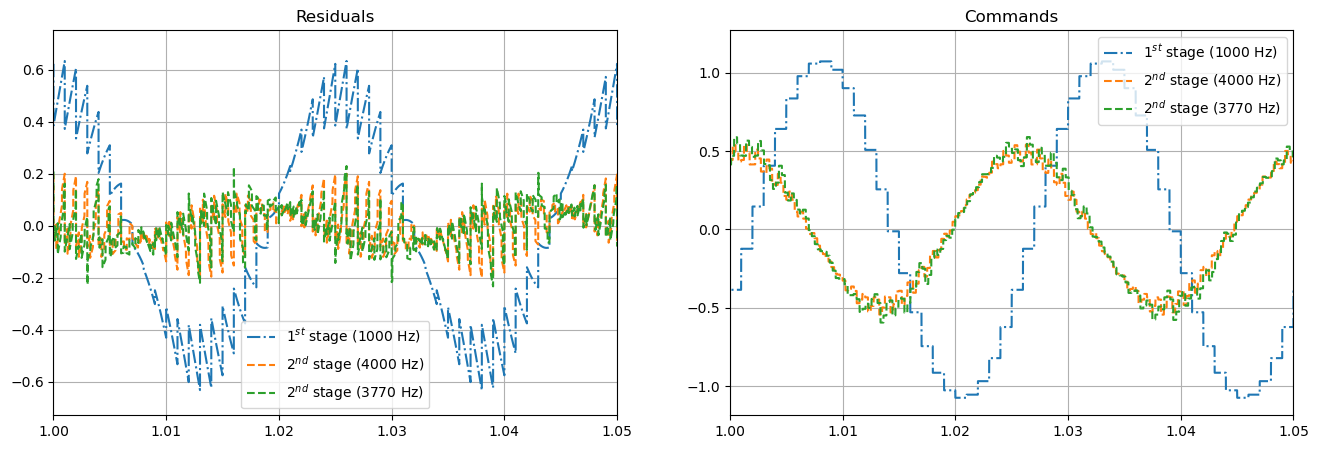

In [27]:
# sinusoid sampled at 100 kHz
fs = 1e+6
freq_in = 40
amp = 1
tend = 2.0

tvec = np.linspace(0,tend,int(fs*tend))
sinus = np.sin(2*np.pi*freq_in*tvec)*amp

gg = 0.7
dd = 2

# First integrator: 1 kHz
f1 = 1e+3
out1,cmd1 = single_integrator(sinus, f1/fs, gain=gg, delay=dd)

# Second integrator: 4 kHz
f2 = 4e+3
out2,cmd2 = single_integrator(out1, f2/fs, gain=gg, delay=dd)

# Second integrator: 3900 Hz
f2bis = 3770
out2bis,cmd2bis = single_integrator(out1, f2bis/fs, gain=gg, delay=dd)

print(int(fs/f1),int(fs/f2),int(fs/f2bis))


plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(tvec,out1,'-.',label=r'$1^{st}$ stage '+f'({f1:1.0f} Hz)')
plt.plot(tvec,out2,'--',label=r'$2^{nd}$ stage '+f'({f2:1.0f} Hz)')
plt.plot(tvec,out2bis,'--',label=r'$2^{nd}$ stage '+f'({f2bis:1.0f} Hz)')
plt.title('Residuals')
plt.xlim([1,1+2/freq_in])
plt.legend(loc='lower center')
plt.grid()
plt.subplot(1,2,2)
plt.plot(tvec,cmd1,'-.',label=r'$1^{st}$ stage '+f'({f1:1.0f} Hz)')
plt.plot(tvec,cmd2,'--',label=r'$2^{nd}$ stage '+f'({f2:1.0f} Hz)')
plt.plot(tvec,cmd2bis,'--',label=r'$2^{nd}$ stage '+f'({f2bis:1.0f} Hz)')
plt.title('Commands')
plt.xlim([1,1+2/freq_in])
plt.legend(loc='upper right')
plt.grid()

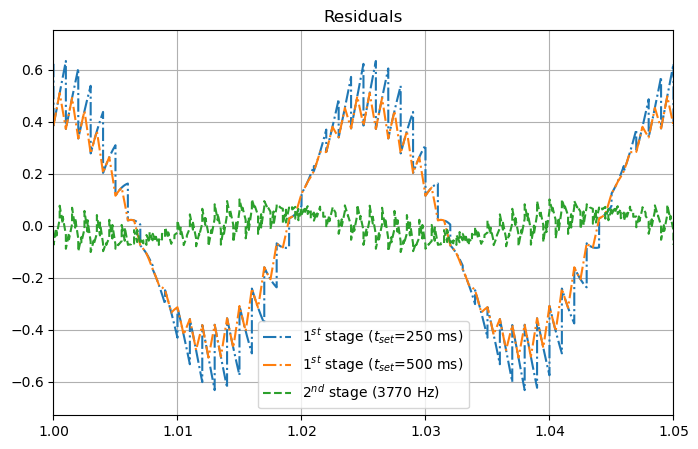

In [34]:
cmd1ps = add_settling_time(cmd1,cmd_steps=int(fs/f1),set_steps=int(fs/f1/2))

out1ps = sinus-cmd1ps
out2ps,cmd2ps = single_integrator(sinus-cmd1ps, f2/fs, gain=gg, delay=dd)

plt.figure(figsize=(8,5))
plt.plot(tvec,out1,'-.',label=r'$1^{st}$ stage ($t_{set}$=250 ms)')
plt.plot(tvec,out1ps,'-.',label=r'$1^{st}$ stage ($t_{set}$=500 ms)')
plt.plot(tvec,out2ps,'--',label=r'$2^{nd}$ stage '+f'({f2bis:1.0f} Hz)')
plt.title('Residuals')
plt.xlim([1,1+2/freq_in])
plt.legend(loc='lower center')
plt.grid()


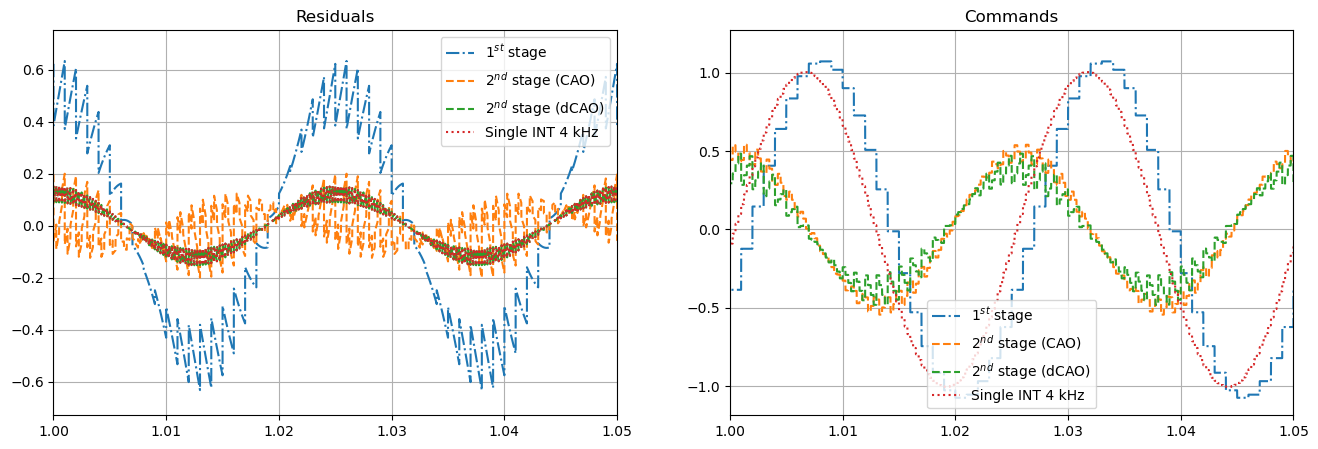

In [29]:
# Single integrator: 4 kHz
out2s,cmd2s = single_integrator(sinus, f2/fs, gain=gg, delay=dd)


# Second stage integrator: 4 kHz + compensation
out2c,cmd2c = single_integrator(out1, f2/fs, gain=gg, delay=dd, cmd_offset=-cmd1)
# out1_dcao = out1.copy()
# out1_dcao[int(2/(f1/fs)):] += cmd1[:-int(2/(f1/fs))]
# out2c,cmd2c = single_integrator(out1_dcao, f2/fs, gain=1.0, delay=2)


plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
plt.plot(tvec,cmd1,'-.',label=r'$1^{st}$ stage')
plt.plot(tvec,cmd2,'--',label=r'$2^{nd}$ stage (CAO)')
plt.plot(tvec,cmd2c,'--',label=r'$2^{nd}$ stage (dCAO)')
plt.plot(tvec,cmd2s,':',label='Single INT 4 kHz')
plt.title('Commands')
plt.xlim([1,1+2/freq_in])
plt.legend(loc='lower center')
plt.grid()
plt.subplot(1,2,1)
plt.plot(tvec,out1,'-.',label=r'$1^{st}$ stage')
plt.plot(tvec,out2,'--',label=r'$2^{nd}$ stage (CAO)')
plt.plot(tvec,out2c,'--',label=r'$2^{nd}$ stage (dCAO)')
plt.plot(tvec,out2s,':',label='Single INT 4 kHz')
plt.title('Residuals')
plt.xlim([1,1+2/freq_in])
plt.legend(loc='upper right')
plt.grid()

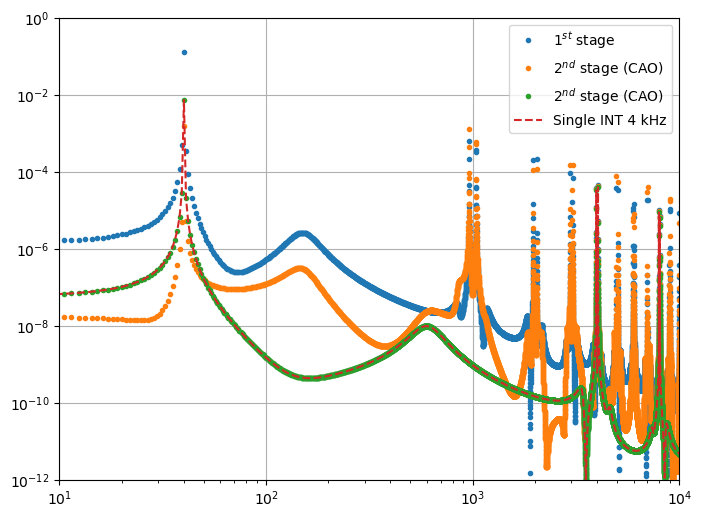

In [30]:
psd,fvec = get_psd(sinus,dt=1/fs,Nsteps=2**20)
psd1,fvec = get_psd(out1,dt=1/fs,Nsteps=2**20)
psd2,fvec = get_psd(out2,dt=1/fs,Nsteps=2**20)
psd2nm,fvec = get_psd(out2bis,dt=1/fs,Nsteps=2**20)
psd2c,fvec = get_psd(out2c,dt=1/fs,Nsteps=2**20)
psd2si,fvec = get_psd(out2s,dt=1/fs,Nsteps=2**20)

plt.figure(figsize=(8,6))
# plt.plot(fvec,psd,'.',label='input')
plt.plot(fvec,psd1,'.',label=r'$1^{st}$ stage')# '+f'({f1:1.0f} Hz)')
plt.plot(fvec,psd2,'.',label=r'$2^{nd}$ stage (CAO)')# '+f'({f2:1.0f} Hz)')
# plt.plot(fvec,psd2nm,'.',label=r'$2^{nd}$ stage '+f'({f2bis:1.0f} Hz)')
plt.plot(fvec,psd2c,'.',label=r'$2^{nd}$ stage (CAO)')
plt.plot(fvec,psd2si,'--',label='Single INT 4 kHz')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,1e+4])
plt.ylim([1e-12,1])
plt.grid()